In [3]:
!pip install scikeras

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import time  # For timing
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score,
    f1_score, precision_score, recall_score, confusion_matrix
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import xgboost as xgb
import lightgbm as lgb
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def show_label_distribution(df, label_col="label", dataset_name="Dataset"):
    print(f"\n=== Label Distribution in {dataset_name} ===")
    label_counts = df[label_col].value_counts().sort_index()
    labels = label_counts.index

    # Determine which label mapping to use
    if len(labels) == 2:
        label_names = [label_mapping_binary[label] for label in labels]
    else:
        label_names = [label_mapping_multiclass[label] for label in labels]

    for label, count in label_counts.items():
        print(f"  {label_names[label]} : {count} ({count / len(df)*100:.2f}%)")

    plt.figure(figsize=(8, 6))
    plt.bar(label_names, label_counts.values, color='skyblue')
    plt.title(f'{dataset_name} - Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [3]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm")

# Initialize stemmer
stemmer = SnowballStemmer("english")

# Define stopwords
stop_words = set(stopwords.words('english'))

def advanced_preprocess(text):
    """
    Advanced text preprocessing with spaCy:
      - Tokenize using spaCy
      - Remove stopwords and punctuation
      - Lemmatize
      - Apply stemming
      - Return cleaned text as a single string
    """
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_punct or token.is_space:
            continue
        lemma = token.lemma_.strip().lower()
        if lemma and lemma not in stop_words:
            stemmed = stemmer.stem(lemma)
            tokens.append(stemmed)
    return ' '.join(tokens)

In [4]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluates the trained model on a given dataset and prints performance metrics.

    Parameters:
    - model: Trained model object
    - X: Features
    - y: True labels
    - dataset_name: String name of the dataset
    """
    y_pred = model.predict(X)

    if hasattr(model, "predict_proba"):
        y_pred_classes = y_pred
    else:
        # For models like SVM without predict_proba, use predict
        y_pred_classes = y_pred

    acc = accuracy_score(y, y_pred_classes)
    f1 = f1_score(y, y_pred_classes, average='weighted')
    precision = precision_score(y, y_pred_classes, average='weighted')
    recall = recall_score(y, y_pred_classes, average='weighted')

    print(f"\n=== {dataset_name} Performance ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred_classes, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()

    return acc, f1, precision, recall

Load Data and Explore

*xx2_six_way means LIAR PLUS data will be used for multiclass classification*

In [6]:
train_file = 'train2_binary.csv'
valid_file = 'valid2_binary.csv'
test_file = 'test2_binary.csv'

# Load binary classification dataset
train_data = pd.read_csv(train_file)
valid_data = pd.read_csv(valid_file)
test_data = pd.read_csv(test_file)

In [7]:
# Function to show label distribution
label_mapping_binary = {0: 'False', 1: 'True'}
label_mapping_multiclass = {
    0: 'True',
    1: 'Mostly True',
    2: 'Half True',
    3: 'Barely True',
    4: 'False',
    5: 'Pants on Fire'
}

In [11]:
def show_label_distributions(df, label_col="label", dataset_name="Dataset"):
    print(f"\n=== Label Distribution in {dataset_name} ===")
    label_counts = df[label_col].value_counts().sort_index()
    labels = label_counts.index

    # Convert labels to integers if they are floats
    labels = labels.astype(int)  # This line ensures labels are integers

    # Determine which label mapping to use
    if len(labels) == 2:
        label_names = [label_mapping_binary[label] for label in labels]
    else:
        label_names = [label_mapping_multiclass[label] for label in labels]

    for label, count in label_counts.items():
        # Convert label to integer before using it as an index
        print(f"  {label_names[int(label)]} : {count} ({count / len(df)*100:.2f}%)")

    plt.figure(figsize=(8, 6))
    plt.bar(label_names, label_counts.values, color='skyblue')
    plt.title(f'{dataset_name} - Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


=== Label Distribution in Train Data ===
  False : 4488 (43.83%)
  True : 5752 (56.17%)


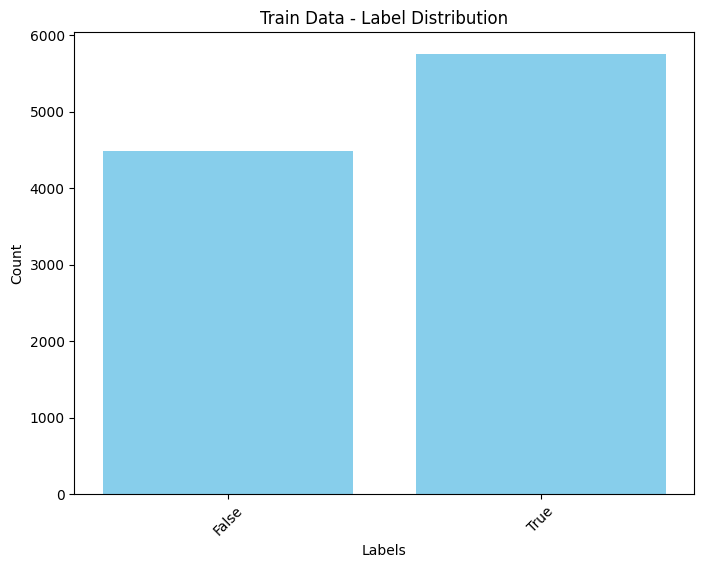


=== Label Distribution in Validation Data ===
  False : 616 (47.98%)
  True : 668 (52.02%)


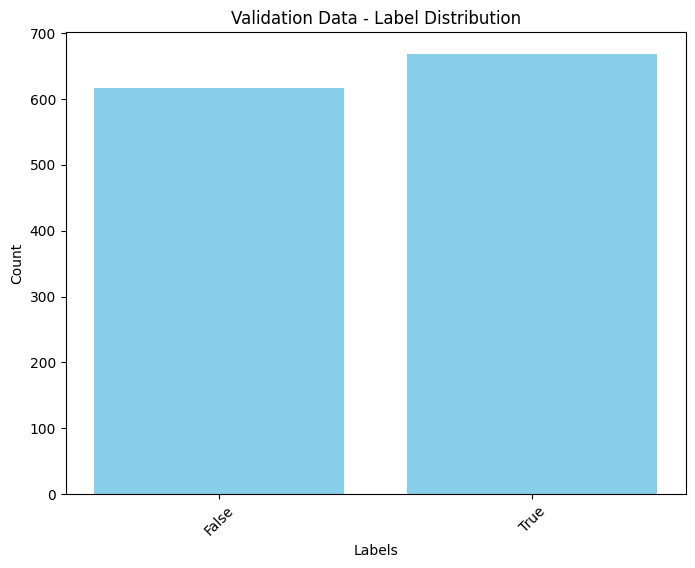


=== Label Distribution in Test Data ===
  False : 553 (43.65%)
  True : 714 (56.35%)


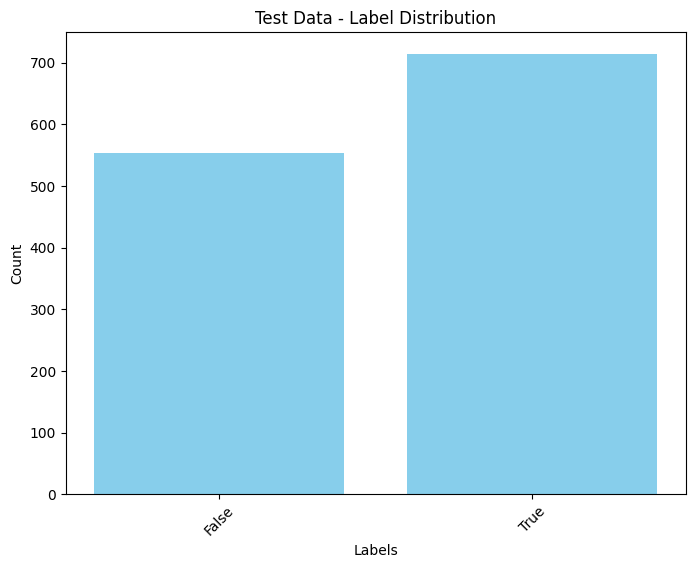

In [12]:
# Show distribution for each dataset
show_label_distributions(train_data, dataset_name="Train Data")
show_label_distributions(valid_data, dataset_name="Validation Data")
show_label_distributions(test_data, dataset_name="Test Data")

Data Preprocessing

In [13]:
# Preprocess Text Data
print("\nPreprocessing text data...")
train_data["cleaned_statement"] = train_data["statement"].apply(advanced_preprocess)
valid_data["cleaned_statement"] = valid_data["statement"].apply(advanced_preprocess)
test_data["cleaned_statement"]  = test_data["statement"].apply(advanced_preprocess)


Preprocessing text data...


Feature Extraction with TF-IDF (bigram)

In [14]:
# Feature Extraction with TF-IDF (Including Bigrams)
print("\nConverting texts to TF-IDF features with bigrams...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Unigrams and Bigrams
tfidf.fit(train_data["cleaned_statement"])

X_train_tfidf = tfidf.transform(train_data["cleaned_statement"]).toarray()
X_valid_tfidf  = tfidf.transform(valid_data["cleaned_statement"]).toarray()
X_test_tfidf  = tfidf.transform(test_data["cleaned_statement"]).toarray()


Converting texts to TF-IDF features with bigrams...


Label Encoding

*is no longer needed as datasets are already encoded*

Handling Class Imbalance

In [15]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data['label']), y=train_data['label'])
class_weights_dict = dict(zip(np.unique(train_data['label']), class_weights))
print("\nClass Weights:")
print(class_weights_dict)

# Assign sample weights
sample_weights = np.array([class_weights_dict[label] for label in train_data['label']])


Class Weights:
{0.0: 1.1408199643493762, 1.0: 0.8901251738525731}


Feature Selection

In [16]:
# Feature Selection and Dimensionality Reduction
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA

# Feature Selection
k = 3000  # Adjust based on computational resources
select_k_best = SelectKBest(score_func=chi2, k=k)
select_k_best.fit(X_train_tfidf, train_data['label'])

X_train_selected = select_k_best.transform(X_train_tfidf)
X_valid_selected = select_k_best.transform(X_valid_tfidf)
X_test_selected = select_k_best.transform(X_test_tfidf)

print(f"\nFeature selection reduced features to {k}. ")



Feature selection reduced features to 3000. 


Hyperparameter Tuning w/o CV

In [17]:
from itertools import product
import random

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Create all combinations
all_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))


Training model 1/5 with parameters:
  n_estimators=500, max_depth=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.8


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:01:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


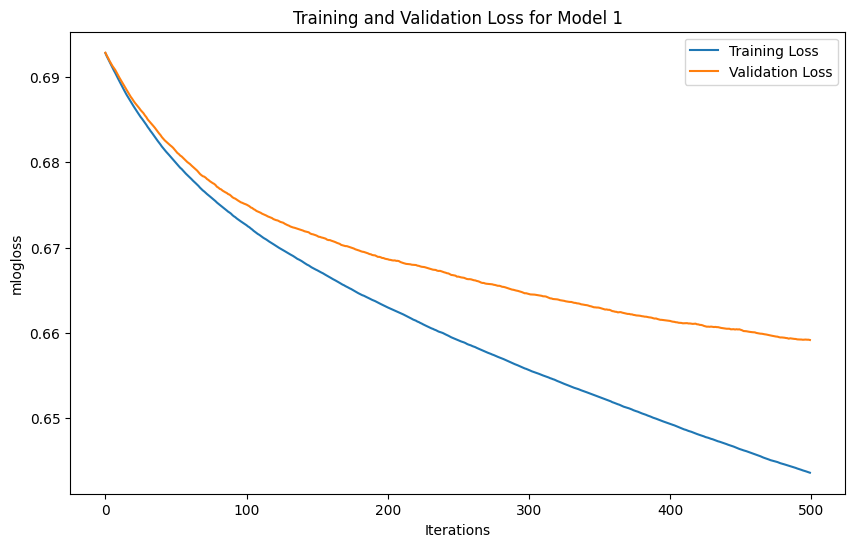


=== Validation Set Performance ===
Accuracy: 0.6051
F1-Score: 0.6050
Precision: 0.6075
Recall: 0.6051

Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.64      0.61       616
        True       0.63      0.58      0.60       668

    accuracy                           0.61      1284
   macro avg       0.61      0.61      0.61      1284
weighted avg       0.61      0.61      0.61      1284


Training model 2/5 with parameters:
  n_estimators=100, max_depth=6, learning_rate=0.01, subsample=0.7, colsample_bytree=0.8


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:14:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


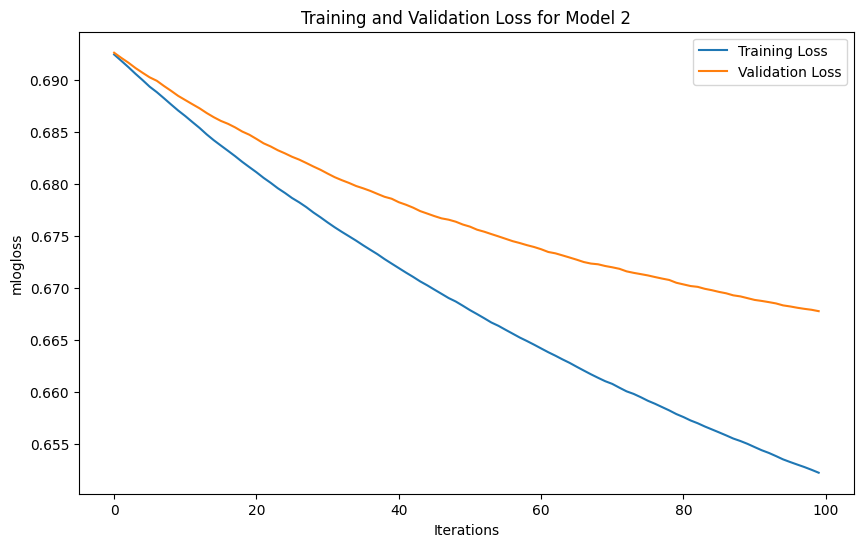


=== Validation Set Performance ===
Accuracy: 0.6106
F1-Score: 0.6100
Precision: 0.6146
Recall: 0.6106

Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.66      0.62       616
        True       0.64      0.56      0.60       668

    accuracy                           0.61      1284
   macro avg       0.61      0.61      0.61      1284
weighted avg       0.61      0.61      0.61      1284


Training model 3/5 with parameters:
  n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.7


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:17:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


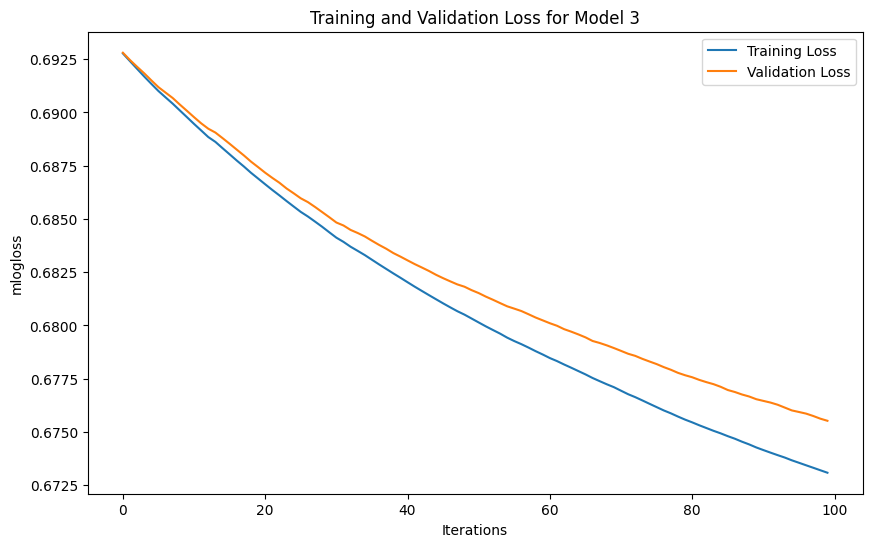


=== Validation Set Performance ===
Accuracy: 0.5732
F1-Score: 0.5639
Precision: 0.5887
Recall: 0.5732

Classification Report:
              precision    recall  f1-score   support

       False       0.54      0.73      0.62       616
        True       0.63      0.43      0.51       668

    accuracy                           0.57      1284
   macro avg       0.59      0.58      0.57      1284
weighted avg       0.59      0.57      0.56      1284


Training model 4/5 with parameters:
  n_estimators=500, max_depth=6, learning_rate=0.01, subsample=0.7, colsample_bytree=0.7


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:20:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


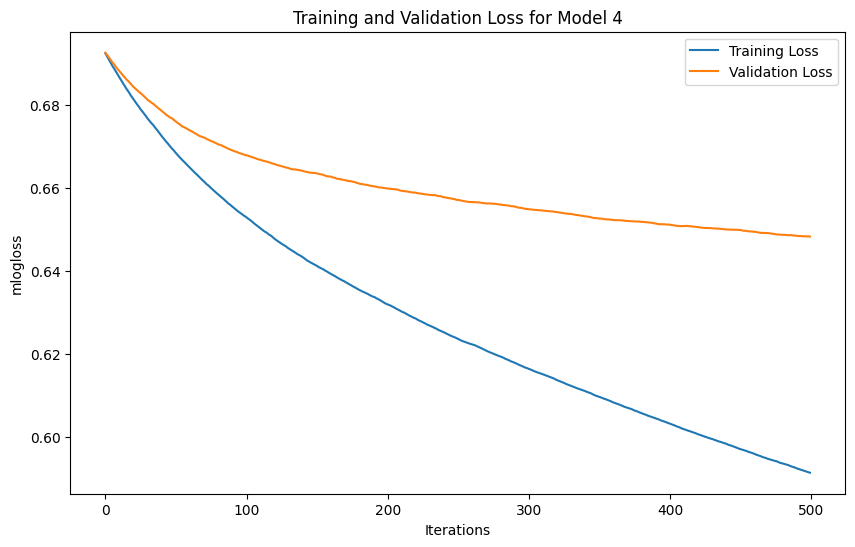


=== Validation Set Performance ===
Accuracy: 0.6207
F1-Score: 0.6208
Precision: 0.6210
Recall: 0.6207

Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.61      0.61       616
        True       0.64      0.63      0.63       668

    accuracy                           0.62      1284
   macro avg       0.62      0.62      0.62      1284
weighted avg       0.62      0.62      0.62      1284


Training model 5/5 with parameters:
  n_estimators=100, max_depth=10, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:35:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


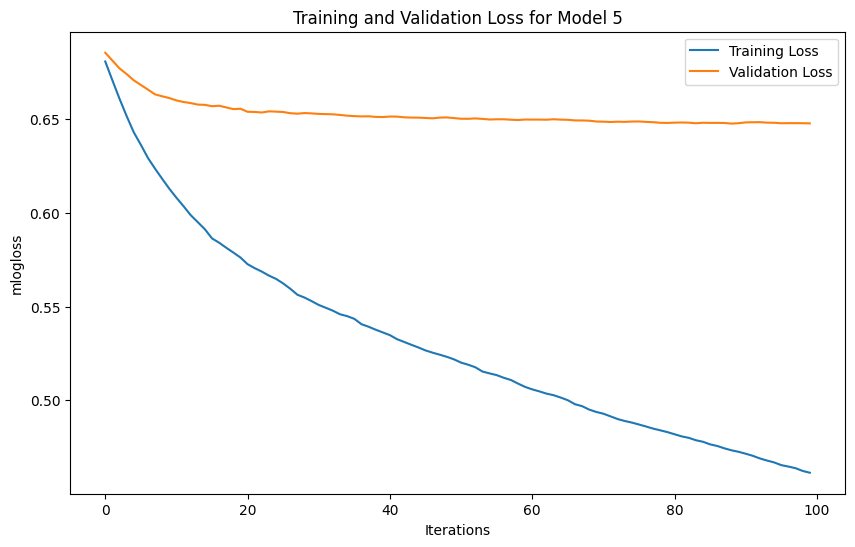


=== Validation Set Performance ===
Accuracy: 0.6176
F1-Score: 0.6172
Precision: 0.6172
Recall: 0.6176

Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.58      0.59       616
        True       0.63      0.65      0.64       668

    accuracy                           0.62      1284
   macro avg       0.62      0.62      0.62      1284
weighted avg       0.62      0.62      0.62      1284



In [18]:
# Hyperparameter Tuning and Model Training
random.seed(42)
selected_combinations = random.sample(all_combinations, 5)  # Limit to 5 hyperparameters

hyperparam_results = []
best_model = None
best_validation_accuracy = 0

# Calculate scale_pos_weight for XGBoost
scale_pos_weight_value = class_weights_dict[1]  # Use positive class weight
num_classes = len(np.unique(train_data['label']))

for idx, (n_estimators, max_depth, learning_rate, subsample, colsample_bytree) in enumerate(selected_combinations, 1):
    print(f"\nTraining model {idx}/{len(selected_combinations)} with parameters:")
    print(f"  n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}")

    model = xgb.XGBClassifier(
        use_label_encoder=False,
        objective='multi:softmax',  # Multi-class classification
        num_class=num_classes,
        eval_metric='mlogloss',
        random_state=42,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        scale_pos_weight=scale_pos_weight_value
    )

    eval_set = [(X_train_selected, train_data['label']), (X_valid_selected, valid_data['label'])]
    evals_result = {}

    start_time = time.time()

    model.fit(
        X_train_selected,
        train_data['label'],
        sample_weight=sample_weights,
        eval_set=eval_set,
        verbose=False,
    )

    end_time = time.time()
    training_time = end_time - start_time

    evals_result = model.evals_result()
    training_loss = evals_result['validation_0']['mlogloss']
    validation_loss = evals_result['validation_1']['mlogloss']

    plt.figure(figsize=(10, 6))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('mlogloss')
    plt.title(f'Training and Validation Loss for Model {idx}')
    plt.legend()
    plt.show()

    # Evaluation function with updated target names
    def evaluate_model(model, X, y, dataset_name):
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')

        print(f"\n=== {dataset_name} Performance ===")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

        if num_classes == 2:
            target_names = ['False', 'True']
        else:
            target_names = ['True', 'Mostly True', 'Half True', 'Barely True', 'False', 'Pants on Fire']

        print("\nClassification Report:")
        print(classification_report(y, y_pred, target_names=target_names))

        return acc, f1, precision, recall

    acc_valid, f1_valid, precision_valid, recall_valid = evaluate_model(model, X_valid_selected, valid_data['label'], 'Validation Set')

    # Track the best model by validation accuracy
    if acc_valid > best_validation_accuracy:
        best_validation_accuracy = acc_valid
        best_model = model

    result = {
        'Model': f'Model {idx}',
        'Parameters': {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree
        },
        'Validation Accuracy': acc_valid,
        'Validation F1-Score': f1_valid,
        'Training Time (s)': round(training_time, 2)
    }

    hyperparam_results.append(result)

Select Best Model

In [19]:
if best_model:
    best_model_info = max(hyperparam_results, key=lambda x: x['Validation Accuracy'])
    print("\nBest Model Based on Validation Accuracy:")
    print(f"Model: {best_model_info['Model']}")
    print("Parameters:")
    for param, value in best_model_info['Parameters'].items():
        print(f"  {param}: {value}")
    print(f"Validation Accuracy: {best_model_info['Validation Accuracy']:.4f}")
    print(f"Validation F1-Score: {best_model_info['Validation F1-Score']:.4f}")
    print(f"Training Time (s): {best_model_info['Training Time (s)']}")

    acc_test, f1_test, precision_test, recall_test = evaluate_model(best_model, X_test_selected, test_data['label'], 'Test Set')
    print("\nFinal Test Results with Best Model:")
    print(f"  Test Accuracy: {acc_test}")
    print(f"  Test F1-Score: {f1_test}")


Best Model Based on Validation Accuracy:
Model: Model 4
Parameters:
  n_estimators: 500
  max_depth: 6
  learning_rate: 0.01
  subsample: 0.7
  colsample_bytree: 0.7
Validation Accuracy: 0.6207
Validation F1-Score: 0.6208
Training Time (s): 888.34

=== Test Set Performance ===
Accuracy: 0.5841
F1-Score: 0.5843
Precision: 0.5845
Recall: 0.5841

Classification Report:
              precision    recall  f1-score   support

       False       0.52      0.53      0.53       553
        True       0.63      0.63      0.63       714

    accuracy                           0.58      1267
   macro avg       0.58      0.58      0.58      1267
weighted avg       0.58      0.58      0.58      1267


Final Test Results with Best Model:
  Test Accuracy: 0.5840568271507498
  Test F1-Score: 0.5842620424068785


Try with the best in LIAR Binary

In [20]:
# Test with specific parameters
specific_model = xgb.XGBClassifier(
    use_label_encoder=False,
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight_value
)

specific_model.fit(
    X_train_selected,
    train_data['label'],
    sample_weight=sample_weights,
    eval_set=[(X_train_selected, train_data['label']), (X_valid_selected, valid_data['label'])],
    verbose=False,
)

acc_test, f1_test, precision_test, recall_test = evaluate_model(specific_model, X_test_selected, test_data['label'], 'Test Set')
print("\nFinal Test Results with Specific Model:")
print(f"  Test Accuracy: {acc_test}")
print(f"  Test F1-Score: {f1_test}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:40:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Test Set Performance ===
Accuracy: 0.5864
F1-Score: 0.5861
Precision: 0.5858
Recall: 0.5864

Classification Report:
              precision    recall  f1-score   support

       False       0.53      0.52      0.52       553
        True       0.63      0.64      0.64       714

    accuracy                           0.59      1267
   macro avg       0.58      0.58      0.58      1267
weighted avg       0.59      0.59      0.59      1267


Final Test Results with Specific Model:
  Test Accuracy: 0.5864246250986582
  Test F1-Score: 0.5860699958240677
